# Finding eigenvalues of matrices with neural networks. 

Script for finding the eigenvectors corresponding to the largest eigenvalue of a matrix with a neural network. The idea is to find the steady state of the differential equation $\frac{dx(t)}{dt} = -x(t) + f(x(t))$ where $f(x) = [x^TxA + (1-x^TAx)I]x$. Since we are looking for the steady state, we set $\frac{dx(t)}{dt} = 0$ and we are left with solving the equation $x = [x^TxA + (1-x^TAx)I]x$. This can done using tensorflow 1. The idea is to set up a neural network that takes an random vector as input and transforms this vector to the solution x. This can be done by introducing the loss function $Loss = MSE(x, f(x))$. The following script is based on the lecture notes in FYS-STK4155. Some parameters can be chosen. num_iter is the maximum number of iterations for the traning of the neural network. learning_rate is the step length in the gradient descent method when traning the neural network. precision is the criteria for when to stop the trianing (if max is not reached). 

## The method is implemented as follows:

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
tf.set_random_seed(83)  #83
import numpy as np
np.random.seed(98) #97
import time

from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# from lib import compute_dx_dt

matrix_size = 6  #Size of the matrix A. 

#Sets up a random symmetric real matrix with dimension (matrix_size, matrix_size). 
A = np.random.random_sample(size=(matrix_size,matrix_size))
A = (A.T + A)/2.0

print(A)

#Saves the matrix for later use. 
start_matrix = A 

#Calculates the analytic eigenvalues. 
eigen_vals, eigen_vecs =  np.linalg.eig(A)

#Converts to tensor so that tensorflow can work with it. Put a minus sign in front to find smallest eigenvalue. 
A = tf.convert_to_tensor(A)
print("A = ", A)

print(eigen_vecs[:,0])

#Initializes a random input vector with the same size as the eigenvectors of A. 
x = np.random.random_sample(size=(1,matrix_size))

# k = eigen_vecs[:,0]
# x -= x.dot(k) * k / np.linalg.norm(k)**2

# print(np.dot(x, k))

#Converts the input to a tensor of correct shape. 
x_0 = tf.convert_to_tensor(tf.reshape(x, shape=(1,-1)))
print("x0 = ", x_0)


num_iter = 10000   #Number of iterations of training the network. 
num_hidden_neurons = [100]      #List of number of neurons in each layer. Add elements to add layers to network. 
num_hidden_layers = np.size(num_hidden_neurons)

#Sets up the network according to specified values above. 
with tf.variable_scope('dnn'):
    previous_layer = x_0

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer

    dnn_output = tf.layers.dense(previous_layer, matrix_size)

#Defines the loss function as described above. 
with tf.name_scope('loss'):
    print("dnn_output = ", dnn_output)
    
    x_trial = tf.transpose(dnn_output)
    print("x_trial = ", x_trial)
    
    #Calculates the parts of the loss function separately. 
    temp1 = (tf.tensordot(tf.transpose(x_trial), x_trial, axes=1)*A)
    temp2 = (1- tf.tensordot(tf.transpose(x_trial), tf.tensordot(A, x_trial, axes=1), axes=1))*np.eye(matrix_size)
    func = tf.tensordot((temp1-temp2), x_trial, axes=1)
    
    print(temp1)
    print(temp2)
    print(func)
    
    func = tf.transpose(func)
    x_trial = tf.transpose(x_trial)
    
    loss = tf.losses.mean_squared_error(func, x_trial)

###
#  SET PARAMETERS 
###
learning_rate = 0.001 # Learning rate for the neural network. 
precision = 0         # Precision treshold. Stops when loss is smaller. 

#Sets up how to train the model. Chooses the optimizer and sets the learning rate chosen.  
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    traning_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

g_dnn = None

losses = []

conv = []
iters = []

time_start = time.time()
with tf.Session() as sess:
    init.run()
    i = 0
#     for i in range(num_iter):
    continue_iter = True
    while i < num_iter and continue_iter:
        sess.run(traning_op)

        if i % 100 == 0:
            l = loss.eval()
            print("Step:", i, "/",num_iter, "loss: ", l)                
            losses.append(l)
            conv.append(x_trial.eval()[0].T)
            iters.append(i)
        if l <= precision:
            break
        i+=1

    x_dnn = x_trial.eval()
x_dnn = x_dnn.T

print("time = ", time.time() - time_start)

[[0.73226725 0.47787427 0.61724428 0.87025615 0.26483054 0.46805582]
 [0.47787427 0.39464279 0.31475892 0.26076868 0.24813765 0.47866796]
 [0.61724428 0.31475892 0.83864138 0.8378511  0.33978901 0.60903542]
 [0.87025615 0.26076868 0.8378511  0.29715185 0.93241803 0.64813176]
 [0.26483054 0.24813765 0.33978901 0.93241803 0.85834939 0.41329663]
 [0.46805582 0.47866796 0.60903542 0.64813176 0.41329663 0.96960967]]
A =  Tensor("Const:0", shape=(6, 6), dtype=float64)
[0.42200924 0.2582136  0.44667136 0.47008326 0.37705241 0.43883009]
x0 =  Tensor("Reshape:0", shape=(1, 6), dtype=float64)
dnn_output =  Tensor("dnn/dense_1/BiasAdd:0", shape=(1, 6), dtype=float64)
x_trial =  Tensor("loss/transpose:0", shape=(6, 1), dtype=float64)
Tensor("loss/mul:0", shape=(6, 6), dtype=float64)
Tensor("loss/mul_1:0", shape=(6, 6), dtype=float64)
Tensor("loss/Tensordot_3:0", shape=(6, 1), dtype=float64)
Step: 0 / 10000 loss:  0.9714878
Step: 100 / 10000 loss:  0.005677818
Step: 200 / 10000 loss:  0.0010859716


## Plotting loss over time

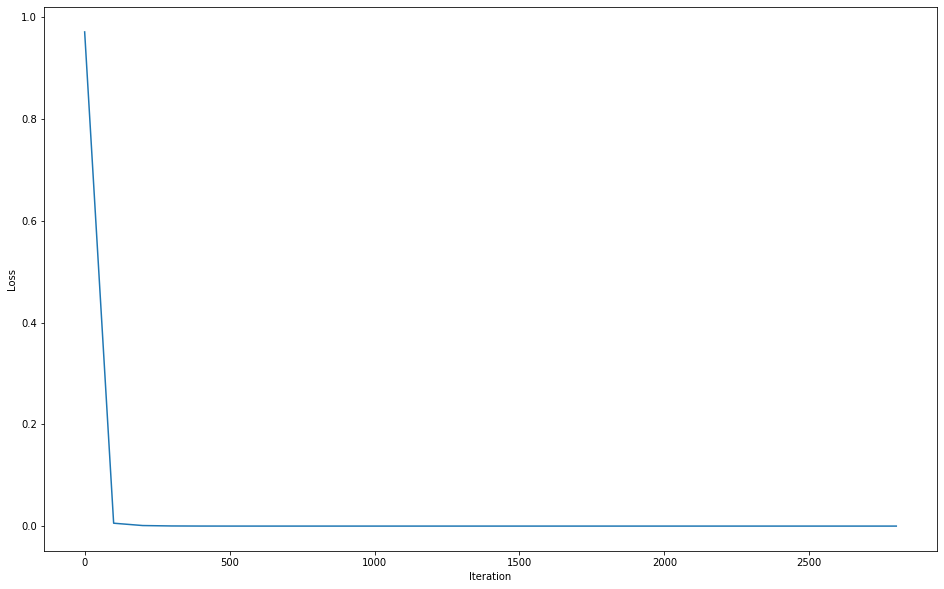

In [3]:
plot_length = 40
plt.figure(figsize=(16,10))
plt.plot(iters[:plot_length],losses[:plot_length])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
plt.close()

## Plotting the components of the eigenvectors as a function of iteration.

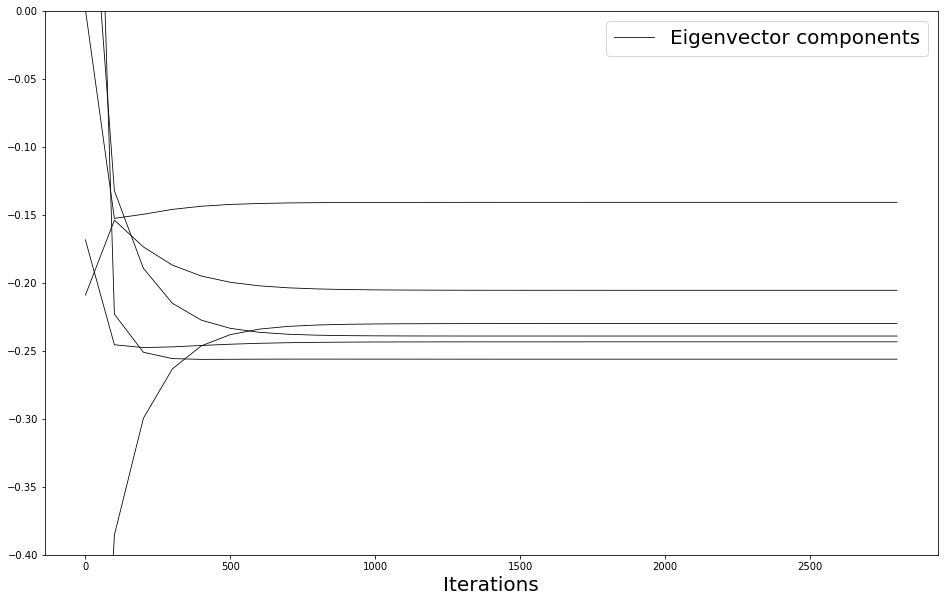

In [4]:
plot_length = 50
plt.figure(figsize=(16,10))
plt.plot(iters[:plot_length], conv[:plot_length], color="k", linewidth=0.8)
plt.ylim(-0.4, 0)
plt.xlabel("Iterations", fontsize=20)
plt.legend(["Eigenvector components"], fontsize=20)
plt.savefig(r"Plots/convergence_of_eigenvector.png")
plt.show()
plt.close()

## Printing eigenvector and eigenvalues

In [5]:
print("Eigenvector NN = \n", (x_dnn/(x_dnn**2).sum()**0.5), "\n")

eigen_val_nn = x_dnn.T @ (start_matrix @ x_dnn) / (x_dnn.T @ x_dnn)

print("Eigenvalue NN = \n", eigen_val_nn, "\n \n")
print("Eigenvector analytic = \n", eigen_vecs)
print("\n")
print("Eigenvalues analytic = \n",eigen_vals)


Eigenvector NN = 
 [[-0.42200925]
 [-0.25821362]
 [-0.44667138]
 [-0.47008322]
 [-0.37705239]
 [-0.4388301 ]] 

Eigenvalue NN = 
 [[3.37070192]] 
 

Eigenvector analytic = 
 [[ 0.42200924  0.34367059 -0.29630828  0.45533274  0.46571911  0.43792459]
 [ 0.2582136  -0.13466039 -0.26108    -0.654866   -0.22909364  0.60472818]
 [ 0.44667136  0.21292646 -0.23276914 -0.46049211  0.32326012 -0.62001247]
 [ 0.47008326 -0.81898912  0.20760118  0.16437036  0.1904933  -0.04330113]
 [ 0.37705241  0.37410143  0.82534911 -0.11086322 -0.09831237  0.12133623]
 [ 0.43883009  0.08788837 -0.25604252  0.33535261 -0.76169003 -0.20374727]]


Eigenvalues analytic = 
 [ 3.37070192 -0.73845294  0.6952692   0.01513973  0.46017383  0.2878306 ]
